# 1. IMPORT


## 1.1 Install libs


In [1]:
# Python: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]

import importlib
import subprocess

def install_package(package, version):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}=={version}...")
        subprocess.check_call(["pip", "install", f"{package}=={version}"])

packages = [
    {"package": "pandas", "version": "2.2.3"},
    {"package": "numpy", "version": "2.2.3"},
    {"package": "matplotlib", "version": "3.10.1"},
    {"package": "seaborn", "version": "0.13.2"},
    {"package": "scipy", "version": "1.15.2"},
    {"package": "scikit-learn", "version": "1.6.1"},
    {"package": "lightgbm", "version": "4.6.0"},
    {"package": "xgboost", "version": "2.1.4"},
]

for pkg in packages:
    install_package(pkg["package"], pkg["version"])

pandas is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
scipy is already installed.
Installing scikit-learn==1.6.1...
lightgbm is already installed.
xgboost is already installed.


## 1.2 Import libs


In [2]:
# Standard library imports
import os  # Provides functions for interacting with the operating system
import re  # Enables regular expression operations
import time  # Provides time-related functions
from collections import Counter  # Implements a counter for counting hashable objects
from pathlib import Path  # Offers a way to interact with files and directories

# Third-party imports
import matplotlib.pyplot as plt  # Collection of functions that make matplotlib work like MATLAB
import numpy as np  # Supports large, multi-dimensional arrays and matrices, along with math functions
import pandas as pd  # Offers data structures and data analysis tools
import seaborn as sns  # Provides a high-level interface for drawing attractive and informative statistical graphics
from scipy.stats import norm, ttest_rel, wilcoxon  # Includes statistical functions, e.g., distributions, tests

# Scikit-learn imports
from sklearn.calibration import label_binarize  # Utility to binarize labels in a one-vs-all fashion
from sklearn.compose import ColumnTransformer  # Applies transformers to columns of an array or pandas DataFrame
from sklearn.dummy import DummyClassifier  # Serves as a simple baseline classifier
from sklearn.ensemble import (  # Includes various ensemble methods
    AdaBoostClassifier,  # AdaBoost classifier
    BaggingClassifier,  # Bagging classifier
    GradientBoostingClassifier,  # Gradient Boosting classifier
    RandomForestClassifier,  # Random Forest classifier
)
from sklearn.metrics import (  # Includes metrics for evaluating model performance
    ConfusionMatrixDisplay,  # Visualizes confusion matrix
    auc,  # Computes Area Under the Curve (AUC)
    confusion_matrix,  # Computes confusion matrix
    f1_score,  # Computes the F1 score
    recall_score,  # Computes recall
    roc_auc_score,  # Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    roc_curve,  # Computes the ROC curve
)
from sklearn.model_selection import (  # Includes tools for model selection
    GridSearchCV,  # Implements exhaustive grid search over specified parameter values for an estimator
    RepeatedStratifiedKFold,  # Provides repeated stratified K-fold cross-validator
    StratifiedKFold,  # Provides stratified K-fold cross-validator
)
from sklearn.naive_bayes import GaussianNB  # Implements Gaussian Naive Bayes algorithm
from sklearn.neighbors import KNeighborsClassifier  # Implements k-Nearest Neighbors algorithm
from sklearn.pipeline import Pipeline  # Chains transformers and estimators
from sklearn.preprocessing import StandardScaler  # Standardizes features by removing the mean and scaling to unit variance
from sklearn.tree import DecisionTreeClassifier  # Implements Decision Tree classifier

# LightGBM and XGBoost imports
from lightgbm import LGBMClassifier  # Implements Light Gradient Boosting Machine classifier
from xgboost import XGBClassifier  # Implements XGBoost classifier

# 2. SETUP


## 2.1 Paths


In [3]:
# =============================================================================
# 1. SETUP: PATHS & OUTPUT FOLDERS
# =============================================================================
INPUT_FOLDER = Path("../data")
OUTPUT_FOLDER = Path("../results")

TABLES_FOLDER    = "tables"
BOXPLOTS_FOLDER  = "boxplots"
ROC_CURVE_FOLDER = "roc_curve"
CONF_MATRIX_FOLDER = "conf_matrix"

output_folder_structure = [
    OUTPUT_FOLDER,
    OUTPUT_FOLDER / "2_labels",
    OUTPUT_FOLDER / "2_labels" / TABLES_FOLDER,
    OUTPUT_FOLDER / "2_labels" / BOXPLOTS_FOLDER,
    OUTPUT_FOLDER / "2_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "2_labels" / CONF_MATRIX_FOLDER,
    OUTPUT_FOLDER / "3_labels",
    OUTPUT_FOLDER / "3_labels" / TABLES_FOLDER,
    OUTPUT_FOLDER / "3_labels" / BOXPLOTS_FOLDER,
    OUTPUT_FOLDER / "3_labels" / ROC_CURVE_FOLDER,
    OUTPUT_FOLDER / "3_labels" / CONF_MATRIX_FOLDER
]

for folder in output_folder_structure:
    folder.mkdir(parents=True, exist_ok=True)

## 2.2 Data


In [4]:
# =============================================================================
# 2. DATA LOADING & PREPARATION
# =============================================================================
data = pd.read_csv(f"{INPUT_FOLDER}/preprocessed_fviii_dataset.csv")
Y = data.pop("Label")
X = data

BINARY_COLUMNS  = X.columns[:3]
NUMERIC_COLUMNS = X.columns[3:]

## 2.3 Metrics


In [5]:
# =============================================================================
# 7. METRICS & DISPLAY CONSTANTS
# =============================================================================
AVERAGE = "macro"
ACCURACY = "accuracy"
F1       = "f1"
RECALL   = "recall"
ROC_AUC  = "roc_auc_ovr"
PPV      = "PPV"
NPV      = "NPV"

MEAN_PREFIX = "Mean"
STD_PREFIX  = "Std"
CI_PREFIX   = "CI"
ALL_PREFIX  = "All"

N_LABELS       = "nLabels"
LABELS_KEY     = "Labels"
CLASSIFIER_KEY = "Classifier"
SCALER_KEY     = "Scaler"

MEAN_ACC     = f"{MEAN_PREFIX} {ACCURACY.capitalize()}"
STD_ACC      = f"{STD_PREFIX} {ACCURACY.capitalize()}"
CI_ACC       = f"{CI_PREFIX} {ACCURACY.capitalize()}"
MEAN_CI_ACC  = f"{ACCURACY.capitalize()}"

MEAN_ROC     = f"{MEAN_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
STD_ROC      = f"{STD_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
CI_ROC       = f"{CI_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
MEAN_CI_ROC  = f"{ROC_AUC.replace('_', ' ').upper()}"

MEAN_F1      = f"{MEAN_PREFIX} {F1.capitalize()}"
STD_F1       = f"{STD_PREFIX} {F1.capitalize()}"
CI_F1        = f"{CI_PREFIX} {F1.capitalize()}"
MEAN_CI_F1   = f"{F1.capitalize()}"

MEAN_REC     = f"{MEAN_PREFIX} {RECALL.capitalize()}"
STD_REC      = f"{STD_PREFIX} {RECALL.capitalize()}"
CI_REC       = f"{CI_PREFIX} {RECALL.capitalize()}"
MEAN_CI_REC  = f"{RECALL.capitalize()}"

BEST_PARAMS  = "Best Hyperparameters Values"
CONF_MATRIX  = "Confusion Matrix"

ALL_ACC      = f"{ALL_PREFIX} {ACCURACY.capitalize()}"
ALL_ROC      = f"{ALL_PREFIX} {ROC_AUC.replace('_', ' ').upper()}"
ALL_F1       = f"{ALL_PREFIX} {F1.capitalize()}"
ALL_REC      = f"{ALL_PREFIX} {RECALL.capitalize()}"
ALL_TRUE     = f"{ALL_PREFIX} True Labels"
ALL_PRED     = f"{ALL_PREFIX} Predictions"
ALL_PROB     = f"{ALL_PREFIX} Probabilities"

SORT_BY      = [MEAN_ACC, MEAN_ROC, MEAN_F1, MEAN_REC]
ROUND_3      = [MEAN_ACC, MEAN_ROC, MEAN_F1, MEAN_REC]
ROUND_2      = [STD_ACC, STD_ROC, STD_F1, STD_REC, CI_ACC, CI_ROC, CI_F1, CI_REC]

COLS_TO_EXPORT = [
    CLASSIFIER_KEY,
    SCALER_KEY,
    MEAN_CI_ACC,
    MEAN_CI_ROC,
    MEAN_CI_F1,
    MEAN_CI_REC,
    BEST_PARAMS
]

## 2.4 Others


In [6]:
# =============================================================================
# 4. CONSTANTS & PARAMETERS
# =============================================================================
N_JOBS       = os.cpu_count()
N_JOBS_NON_OVERFLOW = 1
RANDOM_STATE = 42

# =============================================================================
# 5. CLASSIFIERS & SCALERS
# =============================================================================
CLASSIFIERS = {
    "Dummy": DummyClassifier(random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Bagging": BaggingClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS_NON_OVERFLOW),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1, n_jobs=N_JOBS_NON_OVERFLOW),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, verbosity=0, n_jobs=N_JOBS_NON_OVERFLOW),
}

SCALERS = {
    "None": None,
    "Standard": StandardScaler(),
}


LABELS = {
    "3 Labels": Y,
    "2 Labels": Y.map(lambda lbl: 1 if lbl == 2 else 0),
}
# =============================================================================
# 6. LABELS, CROSS-VALIDATION & SCORING
# =============================================================================

LABEL_UNIQUE = {
    3: Y.unique(),
    2: Y.map(lambda lbl: 1 if lbl == 2 else 0).unique(),
}

PARAM_GRIDS = {
    "AdaBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "Bagging": {"n_estimators": [50, 100, 200]},
    "DecisionTree": {"max_depth": [3, 5, 7]},
    "Dummy": {"strategy": ["stratified", "most_frequent", "prior", "uniform"]},
    "GaussianNB": {},
    "GradientBoosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "KNeighbors": {"n_neighbors": [3, 5, 7]},
    "LightGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
    "RandomForest": {"n_estimators": [100, 200, 300]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]},
}

OUTER_CV   = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
INNER_CV   = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
SCORING_GS = "accuracy"

# 3. FUNCTION


## 3.1 Auxiliar


In [7]:
def get_label_names(n_labels):
    """
    Determine severity labels based on the number of labels provided.
    """
    label_map = {
        2: ["non-severe", "severe"],
        3: ["mild", "moderate", "severe"]
    }
    return label_map.get(n_labels, ["Unknown"] * n_labels)

In [8]:
def get_top_30_best_params(all_best_params):
    """
    Get the most common set of parameters from a list of best parameters.
    """
    # Convert each dictionary to a frozenset of items
    best_params_frozensets = [frozenset(params.items()) for params in all_best_params]
    
    # Count the frequency of each parameter set
    param_counter = Counter(best_params_frozensets)
    
    # Select the most common parameter set and convert it back to a dictionary
    most_common = param_counter.most_common(1)[0][0]
    best_params = dict(most_common)
    
    return best_params

In [9]:
def calculate_confidence_interval(mean, std, all):
    """
    Function to calculate the 95% confidence interval for a given metric.
    """
    if std == 0:
        # With zero standard deviation, return constant interval
        return (np.nan, np.nan)
    
    # Calculate parameters for the confidence interval
    confidence = 0.95               # 95% confidence level
    n = len(all)                    # Number of observations
    stderr = std / np.sqrt(n)       # Standard error of the mean

    # Compute the confidence interval using the normal distribution
    low, high = norm.interval(confidence, loc=mean, scale=stderr)
    
    # Return the rounded interval bounds as a tuple
    return (round(low, 3), round(high, 3))

## 3.2 Analysis


### Statistical Test


In [10]:
def statistical_test(top3_models, my_df):
    """
    Perform Statistical Tests
    """
    # Dynamically create classifier abbreviations from the 'Classifier' column
    classifiers_abbr = {name: name for name in top3_models[CLASSIFIER_KEY].unique()}

    top3_model_names = top3_models[CLASSIFIER_KEY].values
    top3_model_accuracies = [
        my_df[my_df[CLASSIFIER_KEY] == name][ALL_ACC].values[0]
        for name in top3_model_names
    ]
    
    n = len(top3_model_names)
    stat_test_matrix = np.empty((n, n), dtype=object)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                stat_test_matrix[i, j] = classifiers_abbr[top3_model_names[i]]
            elif i < j:
                _, t_pvalue = ttest_rel(top3_model_accuracies[i], top3_model_accuracies[j])
                t_pvalue = f"\\textbf{{{t_pvalue:.2f}}}" if t_pvalue <= 0.05 else f"{t_pvalue:.2f}"
                stat_test_matrix[i, j] = t_pvalue
            else:
                _, w_pvalue = wilcoxon(top3_model_accuracies[i], top3_model_accuracies[j])
                w_pvalue = f"\\textbf{{{w_pvalue:.2f}}}" if w_pvalue <= 0.05 else f"{w_pvalue:.2f}"
                stat_test_matrix[i, j] = w_pvalue
                
    return pd.DataFrame(stat_test_matrix, index=top3_model_names, columns=top3_model_names)

## 3.3 Plots


### Boxplot


In [11]:
def plot_boxplot(my_df, n_labels, init_name, xsize=10, ysize=3):
    """
    Create and save boxplots for accuracy scores.
    """
    # Create output directory for boxplots
    output_dir = Path(OUTPUT_FOLDER) / f"{n_labels}_labels" / "boxplots"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Prepare a copy of the DataFrame
    df = my_df.copy()
    df = df.rename(columns={ALL_ACC: "Accuracy of 30 Folds"})
    
    # Create a new column with combined classifier and scaler info
    df["Boxplot labels"] = df["Classifier"] + " (" + df["Scaler"] + ")"
    
    # Drop duplicate classifiers to ensure unique labels
    df = df.drop_duplicates("Classifier")
    
    # Expand the accuracy scores to multiple rows
    df = df.explode("Accuracy of 30 Folds")

    # Create the boxplot
    plt.figure(figsize=(xsize, ysize))
    sns.boxplot(data=df, y="Boxplot labels", x="Accuracy of 30 Folds", orient="h")

    # Set title based on the number of labels
    if n_labels == 2:
        title = "2 Labels: non-severe, severe"
    elif n_labels == 3:
        title = "3 Labels: mild, moderate, severe"
    else:
        title = f"{n_labels} Labels"
    plt.title(title)
    plt.ylabel("")
    plt.tight_layout()

    # Save and display the plot
    output_path = output_dir / f"{init_name}_{n_labels}_labels_accuracy_boxplots.png"
    plt.savefig(output_path, dpi=300)

### Confusion Matrix


In [12]:
def get_conf_matrix_title(clf_name, scaler_name, label_name):
    """
    Create a formatted title for the confusion matrix plot.
    """
    return f"Confusion Matrix: {clf_name}, {scaler_name}, {label_name}"

def get_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels):
    """
    Create a formatted file path for saving the confusion matrix plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{CONF_MATRIX_FOLDER}/"
        f"ConfMatrix_{clf_name}_{scaler_name}_{label_name}.png"
    )

def plot_confusion_matrix(conf_matrix, clf_name, scaler_name, label_name, n_labels):
    """
    Plot and save the confusion matrix.
    """    
    # Create the title and file path
    title = get_conf_matrix_title(clf_name, scaler_name, label_name)
    file_path = get_conf_matrix_file_path(clf_name, scaler_name, label_name, n_labels)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=get_label_names(n_labels))
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.savefig(file_path)
    plt.close()

### Roc Curve


In [13]:
def get_roc_curve_title(clf_name, scaler_name, label_name, class_name):
    """
    Create a formatted title for the ROC curve plot.
    """
    return f"ROC Curve: {clf_name}, {scaler_name}, {label_name} (Class: {class_name})"


def get_roc_curve_file_path(clf_name, scaler_name, label_name, class_name, n_labels):
    """
    Create a formatted file path for saving the ROC curve plot.
    """
    return (
        f"{OUTPUT_FOLDER}/{n_labels}_labels/{ROC_CURVE_FOLDER}/"
        f"ROCCurve_{clf_name}_{scaler_name}_{label_name}_Class_{class_name}.png"
    )


def plot_roc_curve(fpr, tpr, roc_auc, clf_name, scaler_name, label_name, n_labels, label_names, class_index):
    """
    Plot and save the ROC curve.
    """
    # Create title and file path based on the provided parameters
    title = get_roc_curve_title(clf_name, scaler_name, label_name, label_names[class_index])
    file_path = get_roc_curve_file_path(clf_name, scaler_name, label_name, label_names[class_index], n_labels)
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.close()


def calculate_and_plot_roc_curve(all_true_labels, all_probabilities, clf_name, scaler_name, label_name, n_labels):
    """
    Compute ROC curve and AUC, then plot and save the ROC curve.
    """
    if n_labels == 2:
        # --- Binary classification ---
        fpr, tpr, _ = roc_curve(all_true_labels, all_probabilities[:, 1])
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(
            fpr, tpr, roc_auc,
            clf_name, scaler_name, label_name,
            n_labels, get_label_names(n_labels), 1,
        )
    else:
        # --- Multi-class classification ---
        all_true_labels_bin = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
        for i, class_name in enumerate(np.unique(all_true_labels)):
            fpr, tpr, _ = roc_curve(all_true_labels_bin[:, i], all_probabilities[:, i])
            roc_auc = auc(fpr, tpr)
            plot_roc_curve(
                fpr, tpr, roc_auc,
                clf_name, scaler_name, label_name,
                n_labels, get_label_names(n_labels), i,
            )

## 3.4 Machine Learning


### Nested CV


In [14]:
def cross_val_predict_collect(grid_search, outer_cv, features, labels):
    """
    Cross-Validation with Predictions Collection.
    """
    # Initialize storage for results
    all_true_labels = np.array([])
    all_predictions = np.array([])
    all_probabilities = np.array([])
    all_best_params = []
    
    metrics = {
        ACCURACY: [],
        ROC_AUC: [],
        F1: [],
        RECALL: [],
        PPV: [],
        NPV: [],
    }
    
    for train_index, test_index in outer_cv.split(features, labels):
        # Split data into training and testing sets for this fold
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        # Fit grid search and get the best estimator
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        
        # Predict labels and probabilities on the testing data
        X_test.columns = features.columns
        outer_pred = best_estimator.predict(X_test)
        outer_prob = best_estimator.predict_proba(X_test)
        
        # Collect predictions, probabilities, and best parameters
        all_true_labels = np.append(all_true_labels, y_test)
        all_predictions = np.append(all_predictions, outer_pred)
        all_probabilities = (
            np.vstack([all_probabilities, outer_prob])
            if all_probabilities.size
            else outer_prob
        )
        all_best_params.append(grid_search.best_params_)
        
        # Calculate metrics for this fold
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            roc_auc = roc_auc_score(y_test, outer_prob[:, 1], average=AVERAGE)
        else:
            roc_auc = roc_auc_score(y_test, outer_prob, multi_class="ovr", average=AVERAGE)
        metrics[ROC_AUC].append(roc_auc)
        metrics[ACCURACY].append(best_estimator.score(X_test, y_test))
        metrics[F1].append(f1_score(y_test, outer_pred, average=AVERAGE))
        metrics[RECALL].append(recall_score(y_test, outer_pred, average=AVERAGE))
    
        # Calculate PPV and NPV for each class
        conf_matrix = confusion_matrix(all_true_labels, all_predictions)
        ppv_dict = {}
        npv_dict = {}
        n_classes = len(np.unique(all_true_labels))
        for idx, lab in enumerate(get_label_names(n_classes)):
            TP = conf_matrix[idx, idx]
            FP = conf_matrix[:, idx].sum() - TP
            FN = conf_matrix[idx, :].sum() - TP
            TN = conf_matrix.sum() - (TP + FP + FN)
        
            ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
            npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan
        
            ppv_dict[lab] = ppv
            npv_dict[lab] = npv
        
        metrics[PPV].append(ppv_dict)
        metrics[NPV].append(npv_dict)

    return all_true_labels, all_predictions, all_probabilities, all_best_params, metrics

### Pipeline


In [15]:
def process_pipeline(clf_key, clf, scaler_key, scaler, label_key, label):
    """
    Process the machine learning pipeline for a given classifier, scaler, and labels.
    """
    # Determine number of unique labels and update label names
    n_labels = len(np.unique(label))

    # -------------------------------
    # Pipeline Setup
    # -------------------------------
    preprocessor = (
        ColumnTransformer([("numeric", scaler, NUMERIC_COLUMNS)], remainder="passthrough")
        if scaler is not None
        else "passthrough"
    )
    pipeline = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
    param_grid = {f"clf__{k}": v for k, v in PARAM_GRIDS[clf_key].items()}

    # -------------------------------
    # Grid Search and Cross-Validation
    # -------------------------------
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=param_grid, scoring=SCORING_GS, cv=INNER_CV,
        refit=True, n_jobs=N_JOBS, return_train_score=True
    )
    all_true, all_pred, all_prob, all_best_params, metrics = cross_val_predict_collect(
        grid_search, OUTER_CV, X, label
    )

    # -------------------------------
    # Evaluation: Confusion Matrix & ROC Curve
    # -------------------------------
    conf_matrix = confusion_matrix(all_true, all_pred)
    plot_confusion_matrix(conf_matrix, clf_key, scaler_key, label_key, n_labels)
    # calculate_and_plot_roc_curve(all_true, all_pred, clf_key, scaler_key, label_key, n_labels)

    # -------------------------------
    # Compute Metric Statistics
    # -------------------------------
    def calculate_metrics(metric_values):
        std_val = np.std(metric_values)
        mean_val = np.mean(metric_values)
        ci_low, ci_high = calculate_confidence_interval(mean_val, std_val, metric_values)
        return mean_val, std_val, ci_low, ci_high

    mean_acc, std_acc, ci_acc_low, ci_acc_high = calculate_metrics(metrics[ACCURACY])
    mean_roc, std_roc, ci_roc_low, ci_roc_high = calculate_metrics(metrics[ROC_AUC])
    mean_f1, std_f1, ci_f1_low, ci_f1_high = calculate_metrics(metrics[F1])
    mean_rec, std_rec, ci_rec_low, ci_rec_high = calculate_metrics(metrics[RECALL])
    
    # -------------------------------
    # PPV and NPV Statistics
    # -------------------------------
    all_ppv, all_npv = metrics[PPV], metrics[NPV]
    stats_ppv, stats_npv = {}, {}
    for label in all_ppv[0].keys():
        values = [d[label] for d in all_ppv]
        mean_val, std_val, ci_low, ci_high = calculate_metrics(values)
        stats_ppv[label] = {"mean": f"{mean_val:.3f}", "std": f"{std_val:.2f}", "ci": (f"{ci_low:.2f}", f"{ci_high:.2f}")}

    for label in all_npv[0].keys():
        values = [d[label] for d in all_npv]
        mean_val, std_val, ci_low, ci_high = calculate_metrics(values)
        stats_npv[label] = {"mean": f"{mean_val:.3f}", "std": f"{std_val:.2f}", "ci": (f"{ci_low:.2f}", f"{ci_high:.2f}")}

    # -------------------------------
    # Aggregate and Return Results
    # -------------------------------
    result_dict = {
        N_LABELS: n_labels,
        LABELS_KEY: get_label_names(n_labels),
        CLASSIFIER_KEY: clf_key,
        SCALER_KEY: scaler_key,
        STD_ACC: f"{std_acc:.2f}",
        MEAN_ACC: f"{mean_acc:.3f}",
        CI_ACC: f"({ci_acc_low:.2f}, {ci_acc_high:.2f})",
        MEAN_CI_ACC: f"{mean_acc:.3f} ({std_acc:.2f}, {ci_acc_low:.2f}, {ci_acc_high:.2f})",
        STD_ROC: f"{std_roc:.2f}",
        MEAN_ROC: f"{mean_roc:.3f}",
        CI_ROC: f"({ci_roc_low:.2f}, {ci_roc_high:.2f})",
        MEAN_CI_ROC: f"{mean_roc:.3f} ({std_roc:.2f}, {ci_roc_low:.2f}, {ci_roc_high:.2f})",
        STD_F1: f"{std_f1:.2f}",
        MEAN_F1: f"{mean_f1:.3f}",
        CI_F1: f"({ci_f1_low:.2f}, {ci_f1_high:.2f})",
        MEAN_CI_F1: f"{mean_f1:.3f} ({std_f1:.2f}, {ci_f1_low:.2f}, {ci_f1_high:.2f})",
        STD_REC: f"{std_rec:.2f}",
        MEAN_REC: f"{mean_rec:.3f}",
        CI_REC: f"({ci_rec_low:.2f}, {ci_rec_high:.2f})",
        MEAN_CI_REC: f"{mean_rec:.3f} ({std_rec:.2f}, {ci_rec_low:.2f}, {ci_rec_high:.2f})",
        BEST_PARAMS: {k.replace("clf__", ""): v for k, v in get_top_30_best_params(all_best_params).items()},
        CONF_MATRIX: conf_matrix,
        PPV: stats_ppv,
        NPV: stats_npv,
        ALL_ACC: metrics[ACCURACY],
        ALL_ROC: metrics[ROC_AUC],
        ALL_F1: metrics[F1],
        ALL_REC: metrics[RECALL],
        ALL_TRUE: all_true,
        ALL_PRED: all_pred,
        ALL_PROB: all_prob,
    }
    return result_dict


## 3.5 Results


### Format


In [16]:
def format_nan_max(my_df):
    """
    Replace max of each column with '\\textbf{MAX_VALUE}' and replace 'nan (nan, nan, nan)' with 'NaN'.
    """
    df = my_df.copy()

    df.replace({'nan (nan, nan, nan)': '0.000 (0.00, 0.00, 0.00)'}, inplace=True)

    for column in df.columns:
        max_value = df[column].max()
        df[column] = df[column].replace(max_value, f"\\textbf{{{max_value}}}", regex=False)

    df.replace({'0.000 (0.00, 0.00, 0.00)': 'NaN'}, inplace=True)

    return df

In [17]:
def format_ppv_npv(df, label_names):
    """
    Format PPV and NPV columns and create a new dataframe.
    """
    
    def format_metric(metric_dict):
        return {
            key: f"{vals['mean']} ({vals['std']}, {vals['ci'][0]}, {vals['ci'][1]})"
            for key, vals in metric_dict.items()
        }

    # Apply the formatting to the PPV column and create a new dataframe
    formatted_ppv = df.PPV.apply(format_metric)
    ppv_df = pd.DataFrame(formatted_ppv.tolist())

    # Add Classifier and Scaler columns
    ppv_df['Classifier'] = df['Classifier']
    ppv_df['Scaler'] = df['Scaler']

    # Reorder columns
    ppv_df = ppv_df[['Classifier', 'Scaler'] + label_names]

    # Rename columns
    ppv_df.columns = ['Classifier', 'Scaler'] + [f'PPV {label}' for label in label_names]

    # Merge with NPV columns
    npv_df = pd.DataFrame(df.NPV.apply(format_metric).tolist())
    npv_df = npv_df[label_names]
    npv_df.columns = [f'NPV {label}' for label in label_names]

    # Concatenate PPV and NPV dataframes
    df_ppv_npv = pd.concat([ppv_df, npv_df], axis=1)
    return df_ppv_npv

### Export


In [18]:
def export_df(my_df, file_base, n_labels):
    """
    Export a DataFrame as CSV and LaTeX.
    """
    # Define the output folder path based on the number of labels and tables folder
    output_folder = OUTPUT_FOLDER / f"{n_labels}_labels" / TABLES_FOLDER

    # Create a copy of the DataFrame to avoid modifying the original
    df = my_df.copy()
    
    # Check if the DataFrame contains a column for best hyperparameters and process it
    if 'Best Hyperparameters Values' in df.columns:
        df['Best Hyperparameters Values'] = df['Best Hyperparameters Values'].apply(
            # For each dictionary in the column, replace underscores with "\_" in both keys and values for LaTeX formatting
            lambda x: '{{' + ', '.join(
                f'{str(k).replace("_", "\\_")}: {str(v).replace("_", "\\_")}' for k, v in x.items()
            ) + '}}' if isinstance(x, dict) else x
        )

    # Define file paths for CSV and LaTeX exports
    filepath_csv = os.path.join(output_folder, f"{file_base}_{n_labels}_labels.csv")
    filepath_tex = os.path.join(output_folder, f"{file_base}_{n_labels}_labels.tex")

    # Export DataFrame to CSV without the index column
    df.to_csv(filepath_csv, index=False)
    
    # Export DataFrame to LaTeX format without the index column
    df.to_latex(filepath_tex, index=False)

In [19]:
def export_results(my_df, n_labels):
    """
    Process and export results.
    """
    # Copy the DataFrame to avoid modifying the original one and select all models
    all_models = my_df.copy()
    
    # Select top 3 unique models based on the classifier key and reset the index
    top3_models = all_models.drop_duplicates(CLASSIFIER_KEY).head(3).reset_index(drop=True)
    
    # Perform statistical tests on the top 3 models using all models as reference
    top3_models_stats_test = statistical_test(top3_models, all_models)
    top3_models_stats_test.columns = top3_models_stats_test.index
    
    # Generate boxplots for the complete set of models and for the top 3 models
    plot_boxplot(all_models, n_labels, init_name="all_models")
    plot_boxplot(top3_models, n_labels, init_name="top3_models")
    
    # Prepare the models data to export by selecting specific columns
    all_models_to_export = all_models[COLS_TO_EXPORT]
    top3_models_to_export = top3_models[COLS_TO_EXPORT]

    # Format nan values and add LaTeX formatting to the tables
    all_models_to_export[all_models_to_export.columns[2: -1]] = format_nan_max(all_models_to_export[all_models_to_export.columns[2: -1]])
    top3_models_to_export[top3_models_to_export.columns[2: -1]] = format_nan_max(top3_models_to_export[top3_models_to_export.columns[2: -1]])
    
    # Display the first rows of overall results, top 3 models, and the statistical test matrix
    display(all_models_to_export.head())
    display(top3_models_to_export)
    display(top3_models_stats_test)
    
    # Export the results tables as CSV and LaTeX for further analysis
    export_df(all_models_to_export, "all_models", n_labels)
    export_df(top3_models_to_export, "top3_models", n_labels)
    export_df(top3_models_stats_test, "top3_models_stats_test", n_labels)
    export_df(top3_models_stats_test, "top3_models_stats_test", n_labels)

# 4. RESULT


## 4.1 Run Pipeline


In [20]:
# Initialize list to store ML pipeline results
results = []

# Compute total iterations and initialize counter
max_iterations = len(CLASSIFIERS) * len(SCALERS) * len(LABELS)
iteration_count = 1

# Iterate over each combination of labels, scalers, and classifiers
for label_key, label in LABELS.items():
    # Iterate through available scalers
    for scaler_key, scaler in SCALERS.items():
        # Iterate through available classifiers
        for classifier_key, classifier in CLASSIFIERS.items():
            # Start time for measuring the duration of each iteration
            start_time = time.time()
            
            # Display the current iteration
            print("=" * 80)
            print(f"*** ITERATION {iteration_count}/{max_iterations}")
            print(f"*** LABELS: {label_key}, SCALER: {scaler_key}, CLASSIFIER: {classifier_key}")
            
            # Process the pipeline and collect the result
            result = process_pipeline(
                classifier_key,
                classifier,
                scaler_key,
                scaler,
                label_key,
                label,
            )
            
            # Append the result to the list of results
            results.append(result)
            
            # Increment the iteration counter
            iteration_count += 1
            
            # End time for measuring the duration of each iteration
            end_time = time.time()
            
            # Calculate the elapsed time
            elapsed_time = end_time - start_time
            
            # Print the completion message with elapsed time
            print(f"*** COMPLETED IN {elapsed_time:.2f} SECONDS")

# Create a Pandas DataFrame from the list of results
df_original = pd.DataFrame(results)

*** ITERATION 1/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: Dummy
*** COMPLETED IN 3.02 SECONDS
*** ITERATION 2/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: GaussianNB
*** COMPLETED IN 0.57 SECONDS
*** ITERATION 3/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: DecisionTree
*** COMPLETED IN 1.15 SECONDS
*** ITERATION 4/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: KNeighbors
*** COMPLETED IN 1.45 SECONDS
*** ITERATION 5/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: AdaBoost
*** COMPLETED IN 30.27 SECONDS
*** ITERATION 6/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: Bagging
*** COMPLETED IN 25.37 SECONDS
*** ITERATION 7/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: GradientBoosting
*** COMPLETED IN 83.94 SECONDS
*** ITERATION 8/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: RandomForest
*** COMPLETED IN 21.80 SECONDS
*** ITERATION 9/40
*** LABELS: 3 Labels, SCALER: None, CLASSIFIER: LightGBM
*** COMPLETED IN 12.81 SECONDS
*** ITERATION 10/40
*** L

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

*** COMPLETED IN 18.29 SECONDS
*** ITERATION 20/40
*** LABELS: 3 Labels, SCALER: Standard, CLASSIFIER: XGBoost
*** COMPLETED IN 47.83 SECONDS
*** ITERATION 21/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: Dummy
*** COMPLETED IN 0.87 SECONDS
*** ITERATION 22/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: GaussianNB
*** COMPLETED IN 0.55 SECONDS
*** ITERATION 23/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: DecisionTree
*** COMPLETED IN 1.00 SECONDS
*** ITERATION 24/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: KNeighbors
*** COMPLETED IN 1.61 SECONDS
*** ITERATION 25/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: AdaBoost
*** COMPLETED IN 39.45 SECONDS
*** ITERATION 26/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: Bagging
*** COMPLETED IN 29.34 SECONDS
*** ITERATION 27/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: GradientBoosting
*** COMPLETED IN 36.04 SECONDS
*** ITERATION 28/40
*** LABELS: 2 Labels, SCALER: None, CLASSIFIER: RandomForest
*** COMPLETED

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

*** COMPLETED IN 8.37 SECONDS
*** ITERATION 40/40
*** LABELS: 2 Labels, SCALER: Standard, CLASSIFIER: XGBoost
*** COMPLETED IN 17.32 SECONDS


## 4.2 Format


In [21]:
df = df_original.copy()
df = df.sort_values(by=SORT_BY, ascending=False).reset_index(drop=True)
# display(df.head(3))

cols = ['nLabels', LABELS_KEY] + COLS_TO_EXPORT + [PPV, NPV, ALL_ACC]
df = df[cols]
# display(df.head(3))

## 3 Labels


,nLabels,Labels,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values,PPV,NPV,All Accuracy
0,3,"[mild, moderate, severe]",RandomForest,Standard,"0.655 (0.06, 0.63, 0.68)","0.744 (0.08, 0.72, 0.77)","0.548 (0.08, 0.52, 0.57)","0.555 (0.07, 0.53, 0.58)",{'n_estimators': 200},"{'mild': {'mean': '0.665', 'std': '0.02', 'ci'...","{'mild': {'mean': '0.809', 'std': '0.02', 'ci'...","[0.7380952380952381, 0.6190476190476191, 0.642..."
1,3,"[mild, moderate, severe]",RandomForest,None,"0.651 (0.07, 0.63, 0.67)","0.748 (0.08, 0.72, 0.78)","0.544 (0.08, 0.52, 0.57)","0.552 (0.07, 0.53, 0.57)",{'n_estimators': 200},"{'mild': {'mean': '0.655', 'std': '0.01', 'ci'...","{'mild': {'mean': '0.786', 'std': '0.01', 'ci'...","[0.6904761904761905, 0.5952380952380952, 0.619..."
2,3,"[mild, moderate, severe]",XGBoost,None,"0.639 (0.08, 0.61, 0.67)","0.723 (0.08, 0.69, 0.75)","0.554 (0.08, 0.53, 0.58)","0.556 (0.08, 0.53, 0.58)","{'learning_rate': 1.0, 'n_estimators': 200}","{'mild': {'mean': '0.669', 'std': '0.02', 'ci'...","{'mild': {'mean': '0.769', 'std': '0.01', 'ci'...","[0.6190476190476191, 0.6904761904761905, 0.595..."


/var/folders/zj/skflp_9x1070lcy_zvzlqw9w0000gn/T/ipykernel_11077/3531442841.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_models_to_export[all_models_to_export.columns[2: -1]] = format_nan_max(all_models_to_export[all_models_to_export.columns[2: -1]])
/var/folders/zj/skflp_9x1070lcy_zvzlqw9w0000gn/T/ipykernel_11077/3531442841.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3_models_to_export[top3_models_to_export.columns[2: -1]] = format_nan_max(top3_models_to_export[top3_models_to_export

,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"\textbf{0.655 (0.06, 0.63, 0.68)}","0.744 (0.08, 0.72, 0.77)","0.548 (0.08, 0.52, 0.57)","0.555 (0.07, 0.53, 0.58)",{'n_estimators': 200}
1,RandomForest,None,"0.651 (0.07, 0.63, 0.67)","\textbf{0.748 (0.08, 0.72, 0.78)}","0.544 (0.08, 0.52, 0.57)","0.552 (0.07, 0.53, 0.57)",{'n_estimators': 200}
2,XGBoost,None,"0.639 (0.08, 0.61, 0.67)","0.723 (0.08, 0.69, 0.75)","0.554 (0.08, 0.53, 0.58)","\textbf{0.556 (0.08, 0.53, 0.58)}","{'learning_rate': 1.0, 'n_estimators': 200}"
3,XGBoost,Standard,"0.637 (0.08, 0.61, 0.67)","0.722 (0.08, 0.69, 0.75)","\textbf{0.555 (0.08, 0.53, 0.58)}","0.555 (0.08, 0.53, 0.58)","{'n_estimators': 50, 'learning_rate': 0.1}"
4,Bagging,None,"0.635 (0.08, 0.61, 0.66)","0.735 (0.08, 0.71, 0.76)","0.530 (0.09, 0.50, 0.56)","0.539 (0.08, 0.51, 0.57)",{'n_estimators': 200}


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"\textbf{0.655 (0.06, 0.63, 0.68)}","\textbf{0.744 (0.08, 0.72, 0.77)}","0.548 (0.08, 0.52, 0.57)","0.555 (0.07, 0.53, 0.58)",{'n_estimators': 200}
1,XGBoost,None,"0.639 (0.08, 0.61, 0.67)","0.723 (0.08, 0.69, 0.75)","\textbf{0.554 (0.08, 0.53, 0.58)}","\textbf{0.556 (0.08, 0.53, 0.58)}","{'learning_rate': 1.0, 'n_estimators': 200}"
2,Bagging,None,"0.635 (0.08, 0.61, 0.66)","0.735 (0.08, 0.71, 0.76)","0.530 (0.09, 0.50, 0.56)","0.539 (0.08, 0.51, 0.57)",{'n_estimators': 200}


,RandomForest,XGBoost,Bagging
RandomForest,RandomForest,0.14,\textbf{0.02}
XGBoost,0.14,XGBoost,0.64
Bagging,\textbf{0.03},0.65,Bagging


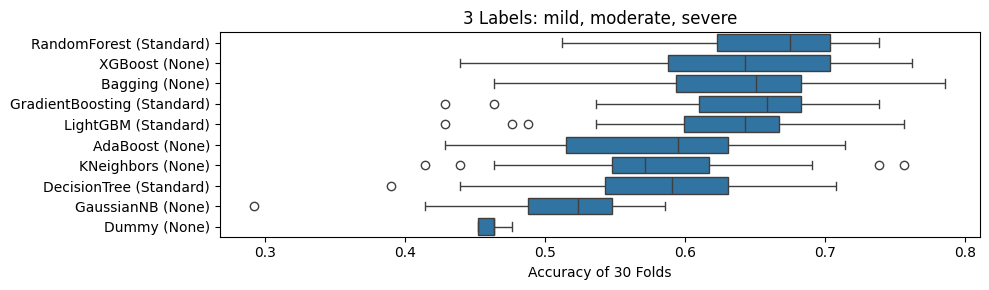

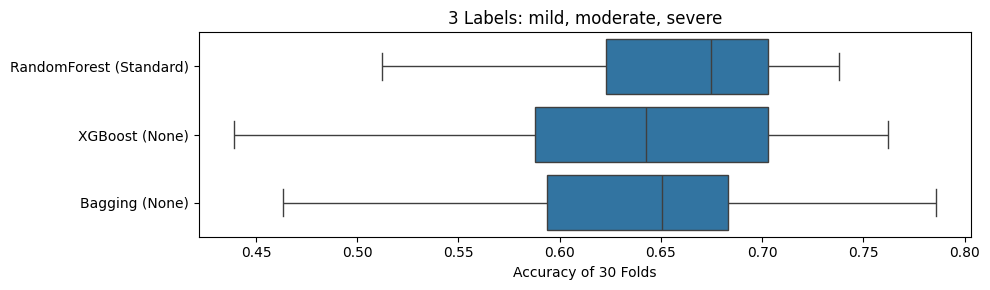

In [22]:
df_3_labels = df[df["nLabels"] == 3].reset_index(drop=True)
display(df_3_labels.head(3))
export_results(df_3_labels, n_labels=3)

In [23]:
df_3_labels_ppv_npv = format_ppv_npv(df_3_labels, ['mild', 'moderate', 'severe'])
df_3_labels_ppv_npv = df_3_labels_ppv_npv[['Classifier', 'Scaler', 'PPV mild', 'NPV mild', 'PPV moderate', 'NPV moderate', 'PPV severe', 'NPV severe']]
# display(df_3_labels_ppv_npv)

df_3_labels_ppv_npv[df_3_labels_ppv_npv.columns[2:]] = format_nan_max(df_3_labels_ppv_npv[df_3_labels_ppv_npv.columns[2:]])
display(df_3_labels_ppv_npv)
export_df(df_3_labels_ppv_npv, "ppv_npv_values", 3)

,Classifier,Scaler,PPV mild,NPV mild,PPV moderate,NPV moderate,PPV severe,NPV severe
0,RandomForest,Standard,"0.665 (0.02, 0.66, 0.67)","0.809 (0.02, 0.80, 0.82)","\textbf{0.559 (0.09, 0.53, 0.59)}","0.850 (0.01, 0.85, 0.85)","0.681 (0.03, 0.67, 0.69)","\textbf{0.823 (0.02, 0.82, 0.83)}"
1,RandomForest,None,"0.655 (0.01, 0.65, 0.66)","0.786 (0.01, 0.78, 0.79)","0.517 (0.10, 0.48, 0.56)","0.849 (0.01, 0.85, 0.85)","0.662 (0.02, 0.65, 0.67)","0.817 (0.02, 0.81, 0.82)"
2,XGBoost,None,"0.669 (0.02, 0.66, 0.68)","0.769 (0.01, 0.77, 0.77)","0.396 (0.07, 0.37, 0.42)","0.855 (0.01, 0.85, 0.86)","0.660 (0.03, 0.65, 0.67)","0.803 (0.01, 0.80, 0.81)"
3,XGBoost,Standard,"\textbf{0.670 (0.02, 0.66, 0.68)}","0.765 (0.01, 0.76, 0.77)","0.410 (0.07, 0.39, 0.43)","\textbf{0.856 (0.01, 0.85, 0.86)}","0.656 (0.03, 0.65, 0.67)","0.803 (0.01, 0.80, 0.81)"
4,Bagging,None,"0.647 (0.02, 0.64, 0.66)","0.778 (0.02, 0.77, 0.78)","0.413 (0.06, 0.39, 0.44)","0.845 (0.00, 0.84, 0.85)","0.675 (0.03, 0.66, 0.69)","0.818 (0.03, 0.81, 0.83)"
5,GradientBoosting,Standard,"0.649 (0.01, 0.65, 0.65)","0.816 (0.03, 0.81, 0.83)","0.429 (0.06, 0.41, 0.45)","0.844 (0.00, 0.84, 0.85)","0.695 (0.04, 0.68, 0.71)","0.807 (0.02, 0.80, 0.81)"
6,Bagging,Standard,"0.649 (0.02, 0.64, 0.66)","0.776 (0.02, 0.77, 0.78)","0.407 (0.07, 0.38, 0.43)","0.845 (0.00, 0.84, 0.85)","0.665 (0.04, 0.65, 0.68)","0.811 (0.02, 0.80, 0.82)"
7,GradientBoosting,None,"0.641 (0.01, 0.64, 0.65)","0.797 (0.04, 0.78, 0.81)","0.416 (0.06, 0.39, 0.44)","0.845 (0.00, 0.84, 0.85)","0.688 (0.04, 0.67, 0.70)","0.804 (0.02, 0.80, 0.81)"
8,LightGBM,Standard,"0.647 (0.03, 0.64, 0.66)","0.797 (0.02, 0.79, 0.80)","0.414 (0.10, 0.38, 0.45)","0.845 (0.01, 0.84, 0.85)","0.669 (0.03, 0.66, 0.68)","0.795 (0.01, 0.79, 0.80)"
9,LightGBM,None,"0.642 (0.01, 0.64, 0.65)","0.779 (0.02, 0.77, 0.79)","0.379 (0.08, 0.35, 0.41)","0.844 (0.01, 0.84, 0.85)","0.661 (0.04, 0.65, 0.67)","0.798 (0.02, 0.79, 0.80)"


## 2 Labels


,nLabels,Labels,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values,PPV,NPV,All Accuracy
0,2,"[non-severe, severe]",RandomForest,Standard,"0.784 (0.06, 0.76, 0.81)","0.808 (0.08, 0.78, 0.84)","0.752 (0.08, 0.72, 0.78)","0.744 (0.08, 0.72, 0.77)",{'n_estimators': 200},"{'non-severe': {'mean': '0.803', 'std': '0.02'...","{'non-severe': {'mean': '0.775', 'std': '0.04'...","[0.8809523809523809, 0.8333333333333334, 0.833..."
1,2,"[non-severe, severe]",RandomForest,None,"0.782 (0.06, 0.76, 0.80)","0.805 (0.08, 0.78, 0.83)","0.752 (0.07, 0.73, 0.78)","0.744 (0.07, 0.72, 0.77)",{'n_estimators': 200},"{'non-severe': {'mean': '0.799', 'std': '0.01'...","{'non-severe': {'mean': '0.763', 'std': '0.04'...","[0.8571428571428571, 0.8333333333333334, 0.785..."
2,2,"[non-severe, severe]",XGBoost,None,"0.772 (0.05, 0.75, 0.79)","0.776 (0.08, 0.75, 0.81)","0.742 (0.06, 0.72, 0.76)","0.736 (0.06, 0.71, 0.76)","{'learning_rate': 0.01, 'n_estimators': 200}","{'non-severe': {'mean': '0.798', 'std': '0.01'...","{'non-severe': {'mean': '0.721', 'std': '0.03'...","[0.8095238095238095, 0.8333333333333334, 0.761..."


/var/folders/zj/skflp_9x1070lcy_zvzlqw9w0000gn/T/ipykernel_11077/3531442841.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_models_to_export[all_models_to_export.columns[2: -1]] = format_nan_max(all_models_to_export[all_models_to_export.columns[2: -1]])
/var/folders/zj/skflp_9x1070lcy_zvzlqw9w0000gn/T/ipykernel_11077/3531442841.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3_models_to_export[top3_models_to_export.columns[2: -1]] = format_nan_max(top3_models_to_export[top3_models_to_export

,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"\textbf{0.784 (0.06, 0.76, 0.81)}","\textbf{0.808 (0.08, 0.78, 0.84)}","\textbf{0.752 (0.08, 0.72, 0.78)}","\textbf{0.744 (0.08, 0.72, 0.77)}",{'n_estimators': 200}
1,RandomForest,None,"0.782 (0.06, 0.76, 0.80)","0.805 (0.08, 0.78, 0.83)","0.752 (0.07, 0.73, 0.78)","0.744 (0.07, 0.72, 0.77)",{'n_estimators': 200}
2,XGBoost,None,"0.772 (0.05, 0.75, 0.79)","0.776 (0.08, 0.75, 0.81)","0.742 (0.06, 0.72, 0.76)","0.736 (0.06, 0.71, 0.76)","{'learning_rate': 0.01, 'n_estimators': 200}"
3,XGBoost,Standard,"0.771 (0.05, 0.75, 0.79)","0.776 (0.08, 0.75, 0.81)","0.741 (0.06, 0.72, 0.76)","0.735 (0.06, 0.71, 0.76)","{'learning_rate': 0.01, 'n_estimators': 200}"
4,Bagging,None,"0.760 (0.07, 0.73, 0.79)","0.787 (0.08, 0.76, 0.82)","0.732 (0.08, 0.70, 0.76)","0.727 (0.08, 0.70, 0.76)",{'n_estimators': 100}


,Classifier,Scaler,Accuracy,ROC AUC OVR,F1,Recall,Best Hyperparameters Values
0,RandomForest,Standard,"\textbf{0.784 (0.06, 0.76, 0.81)}","\textbf{0.808 (0.08, 0.78, 0.84)}","\textbf{0.752 (0.08, 0.72, 0.78)}","\textbf{0.744 (0.08, 0.72, 0.77)}",{'n_estimators': 200}
1,XGBoost,None,"0.772 (0.05, 0.75, 0.79)","0.776 (0.08, 0.75, 0.81)","0.742 (0.06, 0.72, 0.76)","0.736 (0.06, 0.71, 0.76)","{'learning_rate': 0.01, 'n_estimators': 200}"
2,Bagging,None,"0.760 (0.07, 0.73, 0.79)","0.787 (0.08, 0.76, 0.82)","0.732 (0.08, 0.70, 0.76)","0.727 (0.08, 0.70, 0.76)",{'n_estimators': 100}


,RandomForest,XGBoost,Bagging
RandomForest,RandomForest,0.19,\textbf{0.01}
XGBoost,0.30,XGBoost,0.25
Bagging,\textbf{0.01},0.39,Bagging


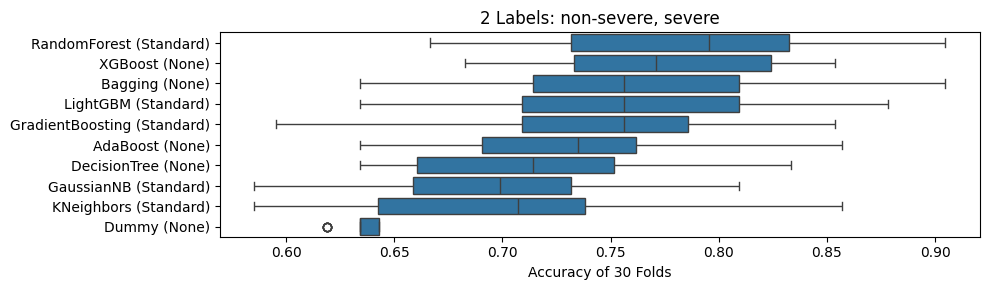

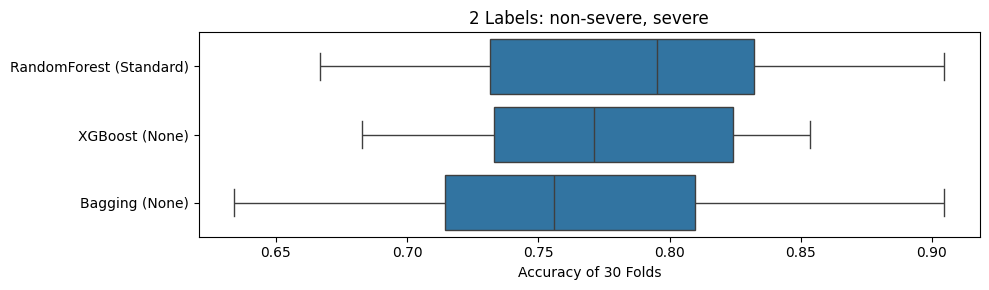

In [24]:
df_2_labels = df[df["nLabels"] == 2].reset_index(drop=True)
display(df_2_labels.head(3))
export_results(df_2_labels, n_labels=2)

In [25]:
df_2_labels_ppv_npv = format_ppv_npv(df_2_labels, ['non-severe', 'severe'])
df_2_labels_ppv_npv = df_2_labels_ppv_npv[['Classifier', 'Scaler', 'PPV non-severe', 'NPV non-severe', 'PPV severe', 'NPV severe']]
# display(df_2_labels_ppv_npv)

df_2_labels_ppv_npv[df_2_labels_ppv_npv.columns[2:]] = format_nan_max(df_2_labels_ppv_npv[df_2_labels_ppv_npv.columns[2:]])
display(df_2_labels_ppv_npv)
export_df(df_2_labels_ppv_npv, "ppv_npv_values", 2)

,Classifier,Scaler,PPV non-severe,NPV non-severe,PPV severe,NPV severe
0,RandomForest,Standard,"\textbf{0.803 (0.02, 0.80, 0.81)}","\textbf{0.775 (0.04, 0.76, 0.79)}","\textbf{0.775 (0.04, 0.76, 0.79)}","\textbf{0.803 (0.02, 0.80, 0.81)}"
1,RandomForest,None,"0.799 (0.01, 0.80, 0.80)","0.763 (0.04, 0.75, 0.78)","0.763 (0.04, 0.75, 0.78)","0.799 (0.01, 0.80, 0.80)"
2,XGBoost,None,"0.798 (0.01, 0.79, 0.80)","0.721 (0.03, 0.71, 0.73)","0.721 (0.03, 0.71, 0.73)","0.798 (0.01, 0.79, 0.80)"
3,XGBoost,Standard,"0.797 (0.01, 0.79, 0.80)","0.721 (0.03, 0.71, 0.73)","0.721 (0.03, 0.71, 0.73)","0.797 (0.01, 0.79, 0.80)"
4,Bagging,None,"0.797 (0.02, 0.79, 0.81)","0.712 (0.05, 0.69, 0.73)","0.712 (0.05, 0.69, 0.73)","0.797 (0.02, 0.79, 0.81)"
5,LightGBM,Standard,"0.781 (0.01, 0.78, 0.78)","0.721 (0.05, 0.70, 0.74)","0.721 (0.05, 0.70, 0.74)","0.781 (0.01, 0.78, 0.78)"
6,Bagging,Standard,"0.791 (0.02, 0.79, 0.80)","0.687 (0.03, 0.68, 0.70)","0.687 (0.03, 0.68, 0.70)","0.791 (0.02, 0.79, 0.80)"
7,GradientBoosting,Standard,"0.775 (0.01, 0.77, 0.78)","0.734 (0.03, 0.72, 0.75)","0.734 (0.03, 0.72, 0.75)","0.775 (0.01, 0.77, 0.78)"
8,GradientBoosting,None,"0.775 (0.01, 0.77, 0.78)","0.735 (0.04, 0.72, 0.75)","0.735 (0.04, 0.72, 0.75)","0.775 (0.01, 0.77, 0.78)"
9,LightGBM,None,"0.778 (0.02, 0.77, 0.78)","0.720 (0.05, 0.70, 0.74)","0.720 (0.05, 0.70, 0.74)","0.778 (0.02, 0.77, 0.78)"
